# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download Face and signature-verification Dataset<a class="anchor" id="1a">

In [ ]:
import opendatasets as od 
import pandas 

od.download('https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/data')
!mv att-database-of-faces faces
!mv faces data/faces
  


In [ ]:
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 
!mv signature-matching/custom signature
!rmdir signature-matching/
!mv signature data

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.Image 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset classes<a class="anchor" id="1b">

##### Face Dataset<a class="anchor" id="1b">

In [ ]:
class FaceNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# Load the training dataset
face_train_folder_dataset = datasets.ImageFolder(root="./data/faces/")
#face_test_folder_dataset = datasets.ImageFolder(root="./data/faces/testing/")


# Resize the images and transform to tensors
# Define the transformations including augmentations
transformation = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Initialize the network
face_train_dataset = FaceNetworkDataset(imageFolderDataset=face_train_folder_dataset, transform=transformation)

train_size = int(0.8 * len(face_train_dataset))
valid_size = len(face_train_dataset) - train_size
face_train_dataset, face_valid_dataset = torch.utils.data.random_split(face_train_dataset, [train_size, valid_size])

train_size = int(0.9 * len(face_train_dataset))
test_size = len(face_train_dataset) - train_size
face_train_dataset, face_test_dataset = torch.utils.data.random_split(face_train_dataset, [train_size, test_size])

#face_test_dataset = FaceNetworkDataset(imageFolderDataset=face_test_folder_dataset, transform=transformation)

print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")


In [ ]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(face_valid_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

##### Signature Dataset<a class="anchor" id="1b">

In [85]:
import pandas as pd
import os
import PIL
class SignatureNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):        
        self.transform = transform
        self.imageFolderDataset = imageFolderDataset
        self.original_images = [img for img in self.imageFolderDataset.imgs if img[1] % 2 == 0]
        self.forged_images = [img for img in self.imageFolderDataset.imgs if img[1] % 2 == 1]

        


    def __getitem__(self, idx):
        img0_tuple = random.choice(self.original_images)

        #We need to approximately 50% of images to be in the same class        
        should_get_same_class = random.randint(0,1) 
        
        if should_get_same_class:
            while True:
                # Find second image of same class, not forged
                img1_tuple = random.choice(self.original_images) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
            
        else:
            while True:
            #Look untill a different class image is found
                img1_tuple = random.choice(self.forged_images) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([should_get_same_class], dtype=np.float32))
        
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [86]:
signature_dataset_folder = datasets.ImageFolder(root="./data/signature/full")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

# Initialize the network
signature_train_dataset = SignatureNetworkDataset(imageFolderDataset=signature_dataset_folder, transform=transformation)

train_size = int(0.8 * len(signature_train_dataset))
valid_size = len(signature_train_dataset) - train_size
signature_train_dataset, signature_valid_dataset = torch.utils.data.random_split(signature_train_dataset, [train_size, valid_size])

train_size = int(0.9 * len(signature_train_dataset))
test_size = len(signature_train_dataset) - train_size
signature_train_dataset, signature_test_dataset = torch.utils.data.random_split(signature_train_dataset, [train_size, test_size])

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")


Number of training samples: 3087
Number of validation samples: 858
Number of testing samples: 344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..1.0].


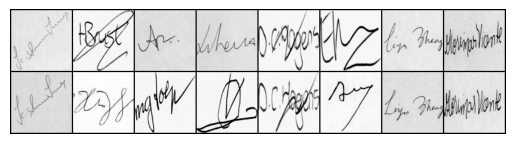

[1. 0. 0. 0. 1. 0. 1. 1.]


In [88]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [89]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 0
 Current loss 8.032657623291016

Validation loss after 10 iterations: 12.583827018737793

Epoch number 1
 Current loss 8.474411964416504

Validation loss after 20 iterations: 12.894370079040527

Epoch number 2
 Current loss 7.886786460876465

Validation loss after 30 iterations: 8.893548011779785

Epoch number 3
 Current loss 7.581503868103027

Validation loss after 40 iterations: 9.986098289489746

Epoch number 4
 Current loss 8.55790901184082

Validation loss after 50 iterations: 7.757876873016357

Epoch number 5
 Current loss 8.097389221191406

Validation loss after 60 iterations: 7.141870021820068

Epoch number 6
 Current loss 7.385374069213867

Validation loss after 70 iterations: 7.165210247039795

Epoch number 7
 Current loss 7.821355819702148

Validation loss after 80 iterations: 6.902393341064453

Epoch number 8
 Current loss 7.912323951721191

Validation loss after 90 iterations: 6.611338138580322

Epoch number 9
 Current loss 6.714226722717285

Validation loss

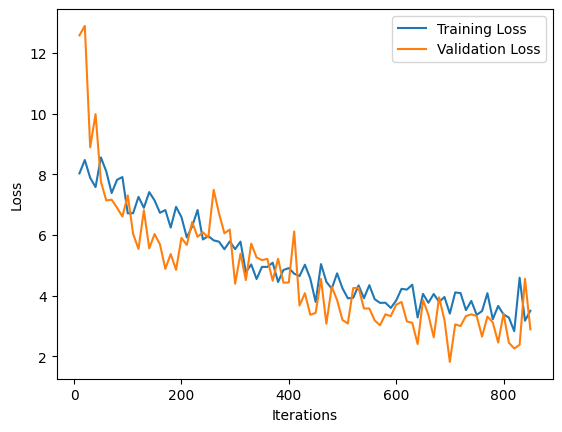

saved model checkpoint


In [69]:
import SiameseFaceNetwork
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=256)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=256)
face_test_loader = DataLoader(face_test_dataset, shuffle=True, num_workers=8, batch_size=256)

face_net = SiameseFaceNetwork.SiameseFaceNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.0001 )
face_net.train_network(train_loader = face_train_loader, val_loader = face_valid_loader, net = face_net, optimizer = optimizer, criterion = criterion, epochs = 200, patience=15)

checkpoint = {'model_state_dict': face_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/face_net.pt')
print('saved model checkpoint')

Epoch number 0
 Current loss 7.3709821701049805

Validation loss after 10 iterations: 13.048275029217756

Epoch number 0
 Current loss 10.842257499694824

Validation loss after 20 iterations: 12.269848788226092

Epoch number 0
 Current loss 7.727777481079102

Validation loss after 30 iterations: 12.17820457175926

Epoch number 0
 Current loss 15.149810791015625

Validation loss after 40 iterations: 11.673067340144405

Epoch number 0
 Current loss 12.960836410522461

Validation loss after 50 iterations: 11.776398517467358

Epoch number 0
 Current loss 14.095136642456055

Validation loss after 60 iterations: 10.929366147076642

Epoch number 0
 Current loss 12.171173095703125

Validation loss after 70 iterations: 11.417364367732295

Epoch number 0
 Current loss 8.320379257202148

Validation loss after 80 iterations: 10.539855232945195

Epoch number 0
 Current loss 7.683789253234863

Validation loss after 90 iterations: 10.235598846718117

Epoch number 0
 Current loss 10.82474136352539

Va

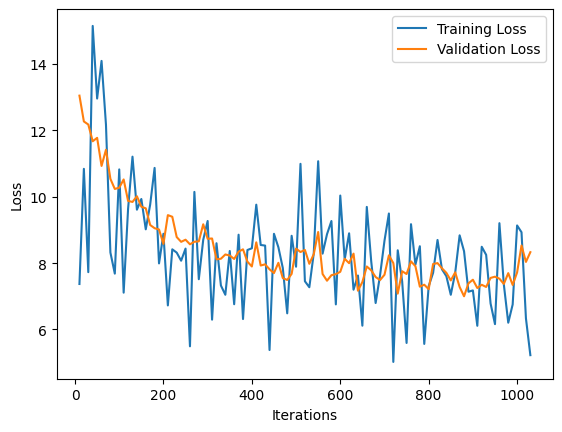

In [92]:
import MultitaskSignatureNet

signature_train_loader = DataLoader(signature_train_dataset, shuffle=True, num_workers=8, batch_size=32)
signature_valid_loader = DataLoader(signature_valid_dataset, shuffle=True, num_workers=8, batch_size=32)

signature_net = MultitaskSignatureNet.SiameseSignatureNetwork().cuda()
criterion = ContrastiveLoss()

optimizer = optim.Adam(signature_net.parameters(), lr = 0.00001)
signature_net.train_network(signature_train_loader, signature_valid_loader, signature_net, optimizer, criterion, epochs=100, patience=15)


In [93]:

checkpoint = {'model_state_dict': signature_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/signature_net.pt')
print('saved model checkpoint')

saved model checkpoint


In [94]:
import SiameseFaceNetwork
import MultitaskSignatureNet


face_net = SiameseFaceNetwork.SiameseFaceNetwork().cuda()
face_model_path = f"./checkpoints/face_net.pt"
face_state_dict = torch.load(face_model_path)
face_net.load_state_dict(face_state_dict['model_state_dict'])

signature_net = MultitaskSignatureNet.SiameseSignatureNetwork().cuda()
signature_model_path = f"./checkpoints/signature_net.pt"
signature_state_dict = torch.load(face_model_path)
signature_net.load_state_dict(signature_state_dict['model_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


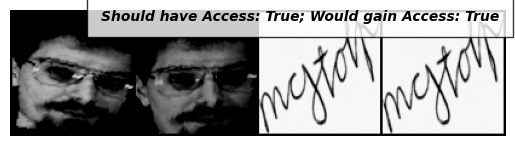

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


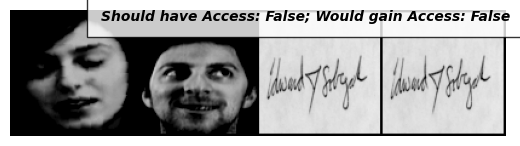

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


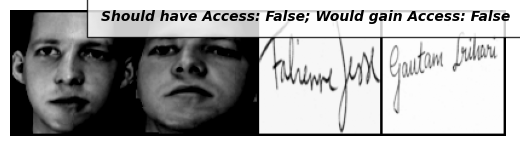

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


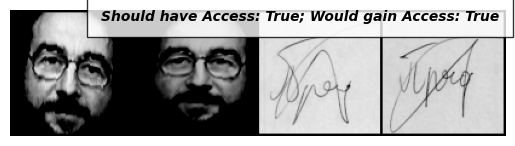

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].


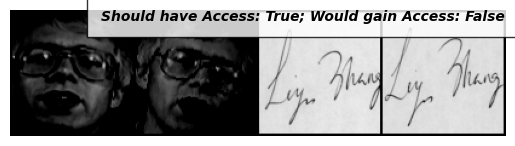

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


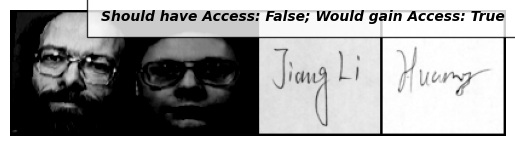

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


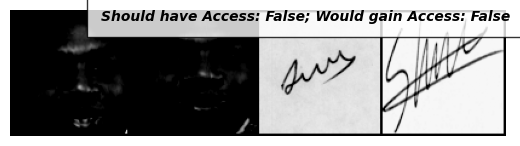

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


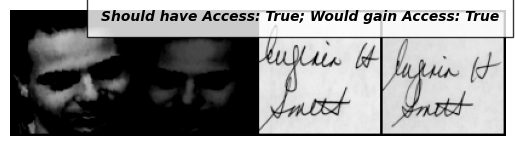

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


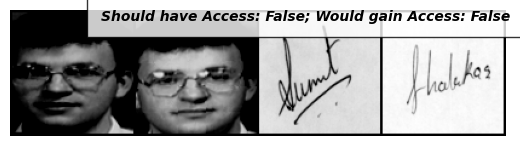

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


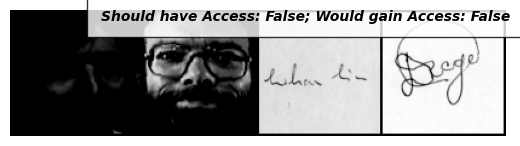

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


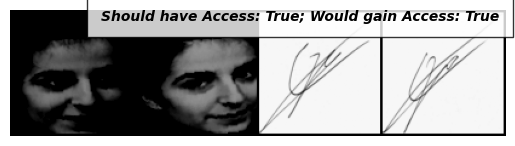

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


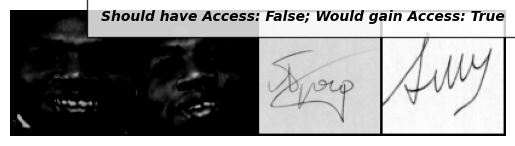

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


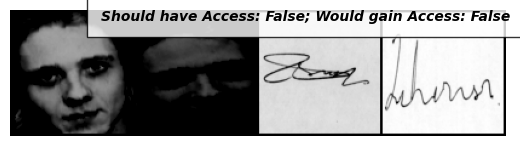

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].


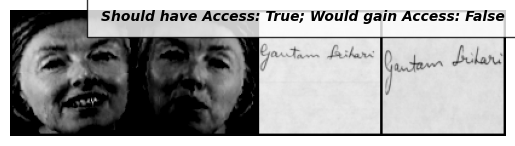

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


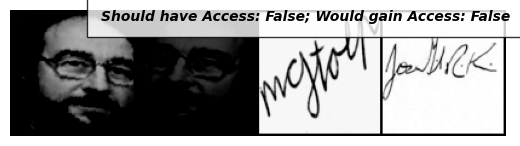

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.96862745].


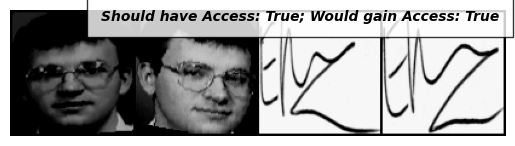

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


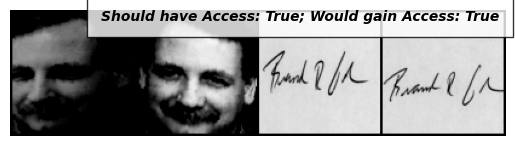

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.8901961].


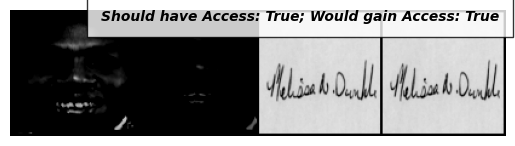

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


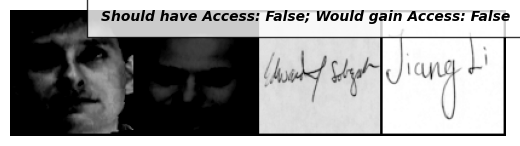

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


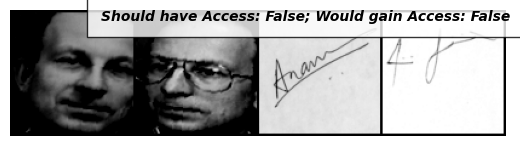

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].


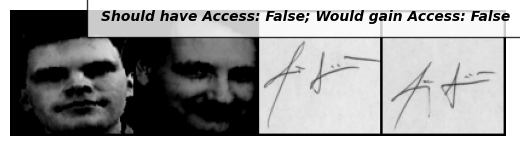

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


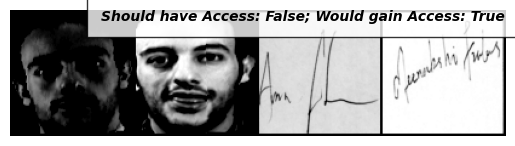

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


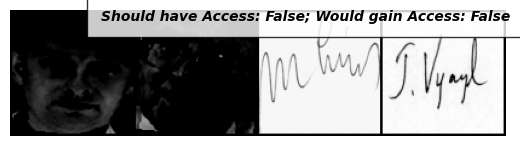

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9607843].


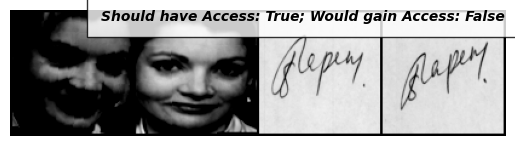

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


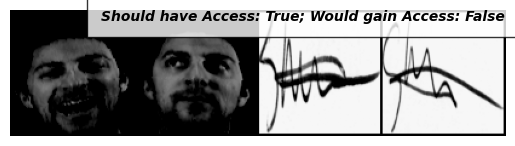

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].


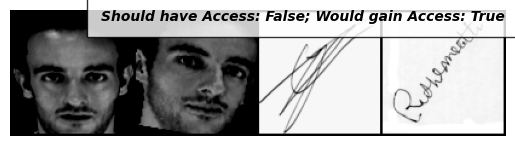

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.96862745].


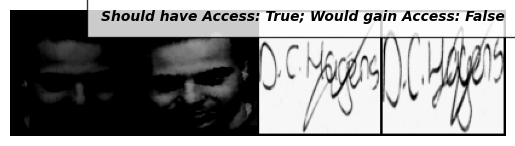

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


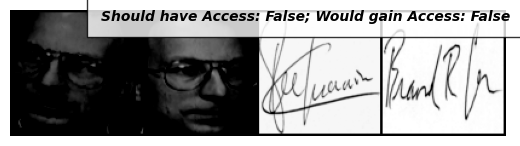

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


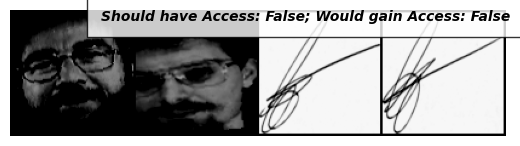

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


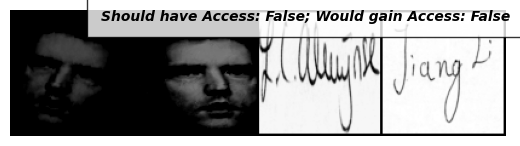

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


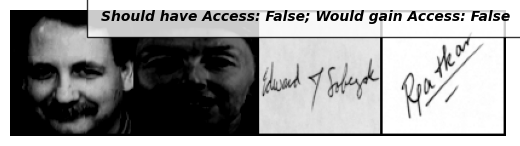

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.96862745].


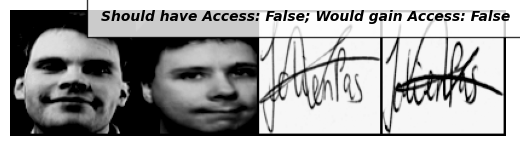

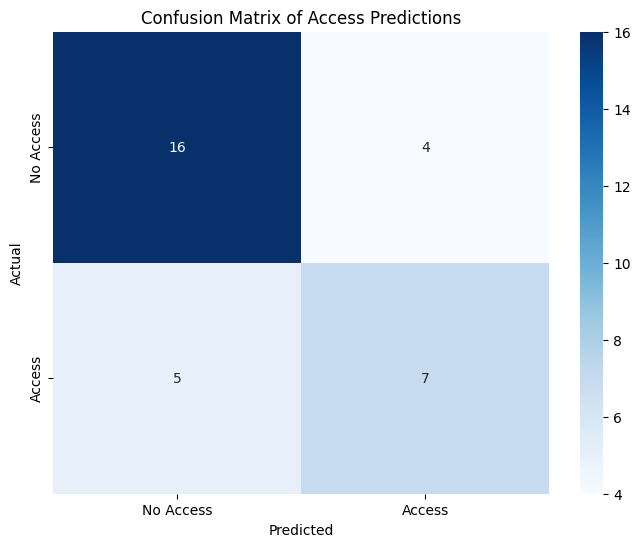

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Locate the test dataset and load it into the SiameseNetworkDataset
face_net.eval()
signature_net.eval()

face_test_dataloader = DataLoader(face_test_dataset, num_workers=2, batch_size=1, shuffle=True)
signature_test_loader = DataLoader(signature_test_dataset, shuffle=True, num_workers=2, batch_size=1)

# Grab one image that we are going to test
face_dataiter = iter(face_test_dataloader)
signature_dataiter = iter(signature_test_loader)

should_have_access_list = []
would_gain_access_list = []

for i in range(len(face_test_dataloader)):
    # Iterate over 5 images and test them with the first image (x0)
    face0, face1, face_label = next(face_dataiter)
    signature1, signature2, forge_label = next(signature_dataiter)

    face_output1, face_output2 = face_net(face0.cuda(), face1.cuda())
    euclidean_distance = F.pairwise_distance(face_output1, face_output2)
    face_distance = (euclidean_distance < 2).bool()

    signature_output1, signature_output2 = signature_net(signature1.cuda(), signature2.cuda())
    #print(torch.sigmoid(forgery_output).bool())
    euclidean_distance = F.pairwise_distance(signature_output1, signature_output2)
    signature_distance = (euclidean_distance < 0.5).bool()
    
    # Concatenate the two images together
    concatenated = torch.cat((face0, face1, signature1, signature2), 0)
    would_gain_access = face_distance.cpu()[0] and signature_distance.cpu()[0]
    should_have_access = not face_label.cpu()[0][0].bool() and forge_label.cpu()[0][0].bool() 
    should_have_access_list.append(should_have_access)
    would_gain_access_list.append(would_gain_access)
    
    imshow(torchvision.utils.make_grid(concatenated), f'Should have Access: {should_have_access}; Would gain Access: {would_gain_access}')


# Create confusion matrix
conf_matrix = confusion_matrix(should_have_access_list, would_gain_access_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Access', 'Access'], yticklabels=['No Access', 'Access'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Access Predictions')
plt.show()